# Assignment 1: Fashion and Housing Multi-layer Perceptron Model Training
## Real-Time 4106
### Gabriel Maldonado

In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets 
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Creates a large trainer class for training and saving metrics of our model
class ModelTrainer:
    
    def __init__(self, model, loss, optimizer, accuracy, model_type, device, classes=0):
        
        # Sets model to GPU and basic loss function and optimizer used
        self.device = device
        self.model = model.to(device)
        self.Loss_Function = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
        self.model_type = model_type
        self.classNum = classes
        
        # Place to store metrics of our model throughout training and testing
        self.Metrics = {"Training Loss":[], "Validation Loss":[], 
                        "Training Accuracy":[], "Validation Accuracy":[],
                        "Test Accuracy":0} 
        
        # Place to save confidence matrix 
        self.ConfMatrix = None
    
    # Defines the training loop for training our model
    def Training_Loop(self, Loader):
        
        # Sets model into training mode
        self.model.train()
        
        # Sets up metric grabing and an accuracy function
        if self.model_type == "Classification":
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy
        
        tLossSum = 0
        tAccuracy = 0
        
        # Iterates through dataloader
        for data, labels in tqdm(Loader):
            
            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)
            
            # Model makes prediction which is passed into a loss function
            pred = self.model(data)
            loss_val = self.Loss_Function(pred, labels)
            
            # Backpropagation model etc, etc...
            self.optimizer.zero_grad()
            loss_val.backward()
            self.optimizer.step()
            
            
            # Set the predictions and labels back into integers for accuracy calculation
            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])
            
            # Running Loss and accuracy
            tLossSum += loss_val.item()
            if self.model_type == "Classification":
                tAccuracy += MCA(pred, labels)
        
        # Update metrics based on running loss and accuracy
        self.Metrics["Training Loss"].append(tLossSum / len(Loader))
        if self.model_type == "Classification":
            self.Metrics["Training Accuracy"].append(tAccuracy / len(Loader))
        
        
    # Defines a function for validating our model is generalizing
    def Validation_Loop(self, Loader):
        
        # Sets model into evaluation mode
        self.model.eval()
        
        # Sets up metric grabing and an accuracy function
        if self.model_type == "Classification":
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy
            
        tLossSum = 0
        tAccuracy = 0
        
        # Iterates through dataloader
        for data, labels in Loader:
            
            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)
            
            # No Backpropagation, use no_grad to get simple prediction and loss
            with torch.no_grad():
                pred = self.model(data)
            loss_val = self.Loss_Function(pred, labels)
            
            # Set the predictions and labels back into integers for accuracy calculation
            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])
            
            # Running Loss and accuracy
            tLossSum += loss_val.item()
            if self.model_type == "Classification":
                tAccuracy += MCA(pred, labels)
            
        # Update metrics based on running loss and accuracy
        self.Metrics["Validation Loss"].append(tLossSum / len(Loader))
        if self.model_type == "Classification":
            self.Metrics["Validation Accuracy"].append(tAccuracy / len(Loader))
        
    
    # Fits model to training while also validating model 
    def fit(self, trainingLoader, validateLoader, EPOCHS):
        
        
        for i in range(EPOCHS):
            
            # Training and Validation loop
            self.Validation_Loop(validateLoader)
            self.Training_Loop(trainingLoader)
                
            # Print epoch metrics
            print("EPOCH:", i+1)
            print("Training Loss:", self.Metrics["Training Loss"][-1], " | Validation Loss:", self.Metrics["Validation Loss"][-1])
            if self.model_type == "Classification":
                print("Training Accuracy:", self.Metrics["Training Accuracy"][-1].item(), " | Validation Accuracy:", self.Metrics["Validation Accuracy"][-1].item())
            
    
    # Evaluate model on data unseen 
    def Test_Model(self, testLoader):
        
        # Sets model into evaluation mode
        self.model.eval()
        
        # Sets up confusion matrix and accuracy
        if self.model_type == "Classification":
            confusion = ConfusionMatrix(task="multiclass", num_classes=self.classNum)
            MCA = self.accuracy(self.classNum)
        else:
            MCA = self.accuracy
        
        # A data structure for storing all labels and predictions
        predMax = torch.empty(0)
        labelMax = torch.empty(0)
    
        # Iterates through dataloader
        for data, labels in testLoader:

            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            data = data.to(self.device)
            if self.model_type == "Classification":
                labels = torch.eye(10)[labels]
            else:
                labels = labels.reshape(-1, 1)
            labels = labels.to(self.device)

            # No Backpropagation, use no_grad to get simple prediction
            with torch.no_grad():
                pred = self.model(data)

            # Set the predictions and labels back into integers for accuracy calculation
            if self.model_type == "Classification":
                pred = torch.Tensor([torch.argmax(i).item() for i in pred])
                labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            # Concatenate labels to store and use later
            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))
        
        # Create confusion matrix and determine accuarcy 
        if self.model_type == "Classification":
            self.ConfMatrix = confusion(predMax, labelMax)
            self.Metrics["Test Accuracy"] = MCA(predMax, labelMax).item()
        
    
    # Show representations of model metrics
    def Graph_Metrics(self):
        
        # Create subplots of a certain size and spacing
        fig, (ax11, ax2) = plt.subplots(1, 2, figsize=(11,4))
        fig.subplots_adjust(wspace=0.3)
        
        # Plot loss of both training and validation on a seperate axis
        ax12 = ax11.twinx()
        ax11.plot(self.Metrics["Training Loss"], color='b')
        ax11.plot(self.Metrics["Validation Loss"], color='c')
        ax11.set_ylabel("Loss")
        ax11.legend(["Training Loss", "Validation Loss"], bbox_to_anchor=(0.40, -0.3), loc='lower right', borderaxespad=0.5)
        
        # Plot accuracy of both training and validation on a seperate axis
        if self.model_type == "Classification":
            ax12.plot(self.Metrics["Training Accuracy"], color='r')
            ax12.plot(self.Metrics["Validation Accuracy"], color='m')
            ax12.set_ylabel("Percentage")
            ax12.legend(["Training Accuracy", "Validation Accuracy"], bbox_to_anchor=(1.02, -0.3), loc='lower right', borderaxespad=0.5)

        ax11.set_title("Model Metrics Across Epochs")

        if self.model_type == "Classification":
            ax2.imshow(self.ConfMatrix, cmap='Blues')

            # Add total number of predictions for each box
            for i in range(self.ConfMatrix.shape[0]):
                for j in range(self.ConfMatrix.shape[1]):
                    ax2.text(j, i, self.ConfMatrix[i, j].item(), ha='center', va='center', color='black')

            # Removes y labels for confusion matrix
            ax2.set_xticks([])
            ax2.set_yticks([])

            ax2.set_xlabel('Predicted labels')
            ax2.set_ylabel('True labels')
            ax2.set_title("Model Confusion Matrix for Test")
        
    def reset(self):
        
        self.Metrics = {"Training Loss":[], "Validation Loss":[], 
                        "Training Accuracy":[], "Validation Accuracy":[],
                        "Test Accuracy":0} 
        
        # Place to save confidence matrix 
        self.ConfMatrix = None

## Problem 1 Fashion Dataset

In [2]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, root, EPOCHS, LR, batchSize):
        self.root = root
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.train_validate_percent = 0.90
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Configuration(root="datasets", EPOCHS=20, LR=0.01, batchSize=128)

In [3]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.2862), (0.3204)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.2862), (0.3204)),
])

In [4]:
train_dataset = datasets.FashionMNIST(root=config.root, train=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root=config.root, train=False, transform=test_transform)

# Splits training dataset into training and validation sets
validNum = int(len(train_dataset) * config.train_validate_percent)
train_dataset, valid_dataset = random_split(train_dataset, [validNum, len(train_dataset) - validNum])


print("Train Dataset:\n", len(train_dataset), "\n\nValidation Dataset:\n", len(valid_dataset), "\n\nTest Dataset:\n", len(test_dataset))

Train Dataset:
 54000 

Validation Dataset:
 6000 

Test Dataset:
 10000


In [5]:
# Determine Normalization of Images

mean, std = 0., 0.
for images, labels in tqdm(test_dataset):
    images = images.view(-1, 28 * 28)
    mean += images.mean()
    std += images.std()

mean /= len(test_dataset)
std /= len(test_dataset)

print("mean: ", mean)
print("std: ", std)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6491.41it/s]

mean:  tensor(0.0020)
std:  tensor(0.9990)


mean and std before normalize:
Mean of the image: tensor([-0.1479])
Std of the image: tensor([0.6445])


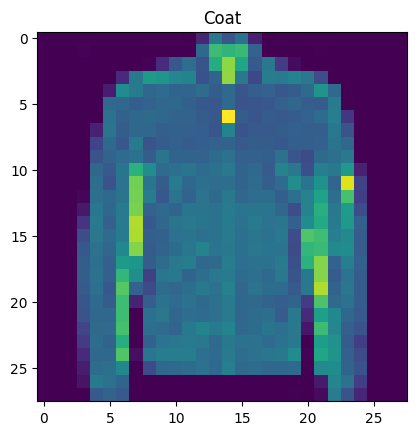

In [6]:
sample = 7

definitions = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

image, label = train_dataset[sample]

mean, std = image.mean([1,2]), image.std([1,2])
 
# print mean and std
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)


image = np.array(image).reshape((28, 28, 1))

# View some of the training Data
plt.imshow(image)
_=plt.title(definitions[label])

In [7]:
trainLoader = DataLoader(train_dataset, batch_size=config.bs, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_dataset, batch_size=config.bs, shuffle=True, num_workers=1)
testLoader = DataLoader(test_dataset, batch_size=config.bs, shuffle=True, num_workers=1)

In [8]:
BaseModel = nn.Sequential(
    nn.Flatten(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.Linear(in_features= 256, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 64),
    nn.ReLU(),
    nn.Linear(in_features= 64, out_features= 10),
)

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
image, label = test_dataset[sample]
BaseModel(image)

tensor([[-0.0298, -0.0784,  0.0296,  0.0179, -0.0219,  0.0538,  0.0877,  0.0486,
         -0.0747,  0.0240]], grad_fn=<AddmmBackward0>)

In [10]:
from utils.Trainer import ModelTrainer

# Setup trainer 
base = copy.deepcopy(BaseModel)
BaseModelTrainer = ModelTrainer(base, nn.CrossEntropyLoss(), torch.optim.SGD(base.parameters(), lr=config.lr, momentum=0.9), MulticlassAccuracy, "Classification",  config.device, 10)

### 1.a Train the model from scratch (with randomized parameters) 10pts

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:08<00:00, 47.22it/s]


EPOCH: 1
Training Loss: 0.7195648906920193  | Validation Loss: 2.2988612601097596
Training Accuracy: 0.7497925162315369  | Validation Accuracy: 0.1432679146528244


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 44.45it/s]


EPOCH: 2
Training Loss: 0.4084209927944775  | Validation Loss: 0.4492400567582313
Training Accuracy: 0.8522209525108337  | Validation Accuracy: 0.8360746502876282


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 41.84it/s]


EPOCH: 3
Training Loss: 0.3575459924566237  | Validation Loss: 0.3922381099868328
Training Accuracy: 0.8706554174423218  | Validation Accuracy: 0.8541138768196106


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.74it/s]


EPOCH: 4
Training Loss: 0.32623416425492524  | Validation Loss: 0.3607317773585624
Training Accuracy: 0.8803703188896179  | Validation Accuracy: 0.872809648513794


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 41.11it/s]


EPOCH: 5
Training Loss: 0.3055169419231008  | Validation Loss: 0.3719465472596757
Training Accuracy: 0.8891103267669678  | Validation Accuracy: 0.8637140989303589


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 40.12it/s]


EPOCH: 6
Training Loss: 0.28852730106685964  | Validation Loss: 0.3504252107219493
Training Accuracy: 0.8940314650535583  | Validation Accuracy: 0.8653290271759033


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.78it/s]


EPOCH: 7
Training Loss: 0.27078471622337097  | Validation Loss: 0.3198575818158211
Training Accuracy: 0.8995757102966309  | Validation Accuracy: 0.8822376132011414


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 45.92it/s]


EPOCH: 8
Training Loss: 0.25677166762651427  | Validation Loss: 0.3191978024675491
Training Accuracy: 0.9047006368637085  | Validation Accuracy: 0.8842616081237793


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 46.56it/s]


EPOCH: 9
Training Loss: 0.24535096401428158  | Validation Loss: 0.3237878233194351
Training Accuracy: 0.9090568423271179  | Validation Accuracy: 0.8843507170677185


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.65it/s]


EPOCH: 10
Training Loss: 0.23280288558011936  | Validation Loss: 0.3278072130806903
Training Accuracy: 0.9134989976882935  | Validation Accuracy: 0.8870614767074585


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.91it/s]


EPOCH: 11
Training Loss: 0.22190179928289772  | Validation Loss: 0.33124814515418194
Training Accuracy: 0.9173182845115662  | Validation Accuracy: 0.8795271515846252


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 40.41it/s]


EPOCH: 12
Training Loss: 0.21284527038510942  | Validation Loss: 0.30652404560687696
Training Accuracy: 0.9208974838256836  | Validation Accuracy: 0.8931373357772827


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 45.33it/s]


EPOCH: 13
Training Loss: 0.20493642865764022  | Validation Loss: 0.33468016379691184
Training Accuracy: 0.9232823252677917  | Validation Accuracy: 0.8849651217460632


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.86it/s]


EPOCH: 14
Training Loss: 0.19476081632183626  | Validation Loss: 0.32328558982686795
Training Accuracy: 0.9275029897689819  | Validation Accuracy: 0.8879880905151367


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.19it/s]


EPOCH: 15
Training Loss: 0.18913120744635142  | Validation Loss: 0.31692868344327235
Training Accuracy: 0.9293741583824158  | Validation Accuracy: 0.8930771350860596


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.05it/s]


EPOCH: 16
Training Loss: 0.177980488404561  | Validation Loss: 0.32318479647027687
Training Accuracy: 0.9343363046646118  | Validation Accuracy: 0.8887414932250977


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.07it/s]


EPOCH: 17
Training Loss: 0.17061945660066266  | Validation Loss: 0.3318825291192278
Training Accuracy: 0.9360448718070984  | Validation Accuracy: 0.8923527598381042


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 41.33it/s]


EPOCH: 18
Training Loss: 0.1668150804371913  | Validation Loss: 0.3243185727203146
Training Accuracy: 0.9391628503799438  | Validation Accuracy: 0.8949604630470276


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.74it/s]


EPOCH: 19
Training Loss: 0.16120585266024015  | Validation Loss: 0.3394676389846396
Training Accuracy: 0.9394784569740295  | Validation Accuracy: 0.8875117301940918


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 41.61it/s]


EPOCH: 20
Training Loss: 0.14980652663962676  | Validation Loss: 0.3355432550640816
Training Accuracy: 0.9437766671180725  | Validation Accuracy: 0.8926426768302917

Test Accuracy: 0.8867999911308289 
Time to Train: 0:04:15.824781


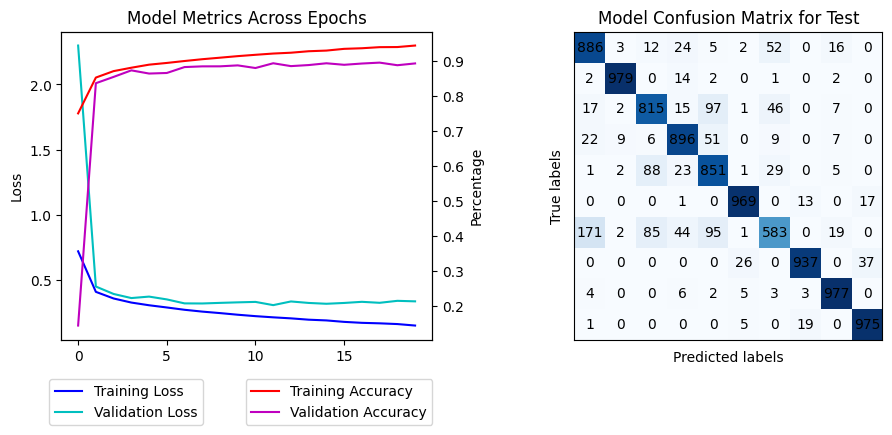

In [11]:
t0 = datetime.now()

# Fit model
BaseModelTrainer.fit(trainLoader, validateLoader, config.EPOCHS)
t1 = datetime.now()
BaseModelTrainer.Test_Model(testLoader)

print("\nTest Accuracy:", BaseModelTrainer.Metrics["Test Accuracy"], "\nTime to Train:", t1 - t0)

BaseModelTrainer.model.to("cpu")
BaseModelTrainer.Graph_Metrics()

### Does your network need more epochs for full training? Do you observe overfitting?
You can begin to see the validation and training metrics greatly diverging overtime. I would consider this model to be overfitting to the training data since while training loss is becoming better, validation loss is not changing. Meaning the model is only improving on the training dataset.

### 1.b This time add weight penalties (weight decays) 15pts

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:08<00:00, 47.60it/s]


EPOCH: 1
Training Loss: 1.0494451045425017  | Validation Loss: 2.2988743224042527
Training Accuracy: 0.6623063087463379  | Validation Accuracy: 0.14203807711601257


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 40.99it/s]


EPOCH: 2
Training Loss: 0.504728624888506  | Validation Loss: 0.5821176177643715
Training Accuracy: 0.8182199001312256  | Validation Accuracy: 0.7884389758110046


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 44.92it/s]


EPOCH: 3
Training Loss: 0.439469922563476  | Validation Loss: 0.4767404515692528
Training Accuracy: 0.8414883017539978  | Validation Accuracy: 0.8274433016777039


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 34.59it/s]


EPOCH: 4
Training Loss: 0.39982455036651465  | Validation Loss: 0.42965065037950556
Training Accuracy: 0.8570064306259155  | Validation Accuracy: 0.8461384177207947


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.06it/s]


EPOCH: 5
Training Loss: 0.37581460915894305  | Validation Loss: 0.4104919452616509
Training Accuracy: 0.8656123876571655  | Validation Accuracy: 0.8527362942695618


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.92it/s]


EPOCH: 6
Training Loss: 0.35706988990448096  | Validation Loss: 0.3877125712151223
Training Accuracy: 0.8721349835395813  | Validation Accuracy: 0.8613486886024475


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.71it/s]


EPOCH: 7
Training Loss: 0.3403079517856593  | Validation Loss: 0.37478665531949795
Training Accuracy: 0.8767019510269165  | Validation Accuracy: 0.8659612536430359


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.78it/s]


EPOCH: 8
Training Loss: 0.32455501790154034  | Validation Loss: 0.36182533077737117
Training Accuracy: 0.8822066187858582  | Validation Accuracy: 0.8738287091255188


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.47it/s]


EPOCH: 9
Training Loss: 0.3130153958548867  | Validation Loss: 0.35350216925144196
Training Accuracy: 0.8859838247299194  | Validation Accuracy: 0.8769444227218628


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.76it/s]


EPOCH: 10
Training Loss: 0.3021003361703095  | Validation Loss: 0.36217912238963107
Training Accuracy: 0.88958740234375  | Validation Accuracy: 0.8742193579673767


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.30it/s]


EPOCH: 11
Training Loss: 0.29324148323439875  | Validation Loss: 0.3405388996322104
Training Accuracy: 0.8931431174278259  | Validation Accuracy: 0.8789828419685364


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.33it/s]


EPOCH: 12
Training Loss: 0.2816827808864309  | Validation Loss: 0.33331482302635274
Training Accuracy: 0.8969566822052002  | Validation Accuracy: 0.8808429837226868


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.29it/s]


EPOCH: 13
Training Loss: 0.2738190556730704  | Validation Loss: 0.3389060310226806
Training Accuracy: 0.8990986943244934  | Validation Accuracy: 0.8813441395759583


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.44it/s]


EPOCH: 14
Training Loss: 0.2647011483096963  | Validation Loss: 0.329665777531076
Training Accuracy: 0.9040138721466064  | Validation Accuracy: 0.8793096542358398


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.79it/s]


EPOCH: 15
Training Loss: 0.25570081880589796  | Validation Loss: 0.32266541491163536
Training Accuracy: 0.9061533808708191  | Validation Accuracy: 0.8840761184692383


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.69it/s]


EPOCH: 16
Training Loss: 0.2507126250467594  | Validation Loss: 0.3230066515029745
Training Accuracy: 0.9086995124816895  | Validation Accuracy: 0.887833297252655


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.79it/s]


EPOCH: 17
Training Loss: 0.24003177434559117  | Validation Loss: 0.318607600762489
Training Accuracy: 0.9120055437088013  | Validation Accuracy: 0.8905639052391052


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.35it/s]


EPOCH: 18
Training Loss: 0.23227303595198273  | Validation Loss: 0.31917709524327137
Training Accuracy: 0.9148773550987244  | Validation Accuracy: 0.8828341960906982


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.50it/s]


EPOCH: 19
Training Loss: 0.22784296928141354  | Validation Loss: 0.3171048773095963
Training Accuracy: 0.9177296161651611  | Validation Accuracy: 0.8908873796463013


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 34.64it/s]


EPOCH: 20
Training Loss: 0.2185914717367475  | Validation Loss: 0.33388136105334504
Training Accuracy: 0.9202534556388855  | Validation Accuracy: 0.8779405355453491

Test Accuracy: 0.8852999806404114 
Time to Train: 0:04:37.286961


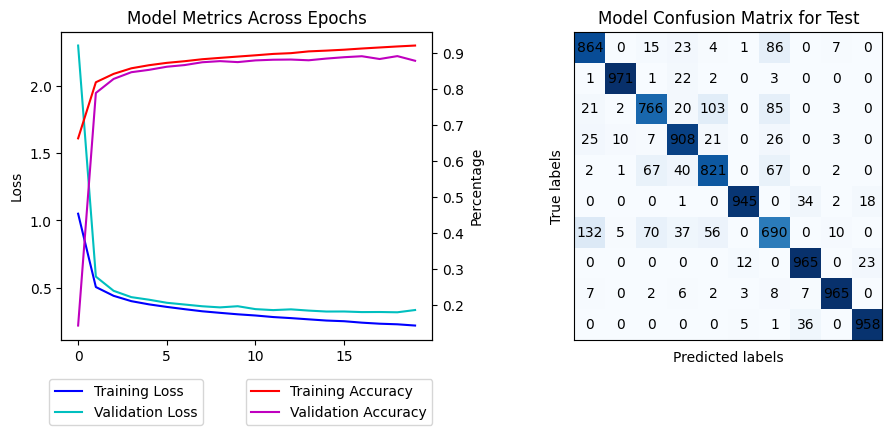

In [63]:
DecayModel = copy.deepcopy(BaseModel)
DecayModelTrainer = ModelTrainer(DecayModel, nn.CrossEntropyLoss(), torch.optim.SGD(DecayModel.parameters(), lr=config.lr, momentum=0.9, weight_decay=0.0001), MulticlassAccuracy, "Classification",  config.device, 10)

t0 = datetime.now()

DecayModelTrainer.fit(trainLoader, validateLoader, config.EPOCHS)
t1 = datetime.now()
DecayModelTrainer.Test_Model(testLoader)

print("\nTest Accuracy:", DecayModelTrainer.Metrics["Test Accuracy"], "\nTime to Train:", t1 - t0)

DecayModelTrainer.model.to("cpu")
DecayModelTrainer.Graph_Metrics()

### How do the training results change compared to the baseline?
As we look at both graphs the training results seem mostly identical, however the generalization gap is slightly less on the weight decay model. This is because weight decay allows weights which are not as heavily used to have the chance of being used due to the strong weights being reduced. This allows a model to better generalize to test data which has not been seen yet. The difference is slight however it is noticable, changing about a percentage.

In [13]:
DropModel = copy.deepcopy(BaseModel)
DropModel.insert(5, nn.Dropout(0.3))
DropModel.insert(8, nn.Dropout(0.3))
print(DropModel)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
)


### 1.c This time add dropout (dropout = 0.3) 15pts

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.42it/s]


EPOCH: 1
Training Loss: 0.8465215059535763  | Validation Loss: 2.2988787965571627
Training Accuracy: 0.695548415184021  | Validation Accuracy: 0.14215900003910065


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.87it/s]


EPOCH: 2
Training Loss: 0.47929433235342467  | Validation Loss: 0.49043538912813717
Training Accuracy: 0.8324177265167236  | Validation Accuracy: 0.8195300102233887


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.48it/s]


EPOCH: 3
Training Loss: 0.4240304200570165  | Validation Loss: 0.4163932552997102
Training Accuracy: 0.851871132850647  | Validation Accuracy: 0.850829005241394


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.72it/s]


EPOCH: 4
Training Loss: 0.3862214969444614  | Validation Loss: 0.37779323312830415
Training Accuracy: 0.8655071258544922  | Validation Accuracy: 0.8605536818504333


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.55it/s]


EPOCH: 5
Training Loss: 0.3645776926906188  | Validation Loss: 0.35655942464128454
Training Accuracy: 0.8731905817985535  | Validation Accuracy: 0.8712466359138489


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.57it/s]


EPOCH: 6
Training Loss: 0.3449035612822144  | Validation Loss: 0.34996636338690496
Training Accuracy: 0.8786380887031555  | Validation Accuracy: 0.8793388605117798


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.95it/s]


EPOCH: 7
Training Loss: 0.32332648029683325  | Validation Loss: 0.35287133556731204
Training Accuracy: 0.8850240111351013  | Validation Accuracy: 0.8755583167076111


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 41.30it/s]


EPOCH: 8
Training Loss: 0.308397461699931  | Validation Loss: 0.3496774948657827
Training Accuracy: 0.8900361061096191  | Validation Accuracy: 0.8741167783737183


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.84it/s]


EPOCH: 9
Training Loss: 0.29620265784139316  | Validation Loss: 0.32082049041352373
Training Accuracy: 0.8941023349761963  | Validation Accuracy: 0.8846558928489685


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 42.53it/s]


EPOCH: 10
Training Loss: 0.287506367216743  | Validation Loss: 0.329113521791519
Training Accuracy: 0.8987356424331665  | Validation Accuracy: 0.883091151714325


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 44.39it/s]


EPOCH: 11
Training Loss: 0.27730460212482094  | Validation Loss: 0.31685706307279304
Training Accuracy: 0.9012190699577332  | Validation Accuracy: 0.8834189772605896


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 45.04it/s]


EPOCH: 12
Training Loss: 0.2666168148271845  | Validation Loss: 0.3184381380994269
Training Accuracy: 0.904383659362793  | Validation Accuracy: 0.8851382732391357


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.19it/s]


EPOCH: 13
Training Loss: 0.25747708097029637  | Validation Loss: 0.3153578692928274
Training Accuracy: 0.9073614478111267  | Validation Accuracy: 0.887162983417511


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.09it/s]


EPOCH: 14
Training Loss: 0.2501642585189139  | Validation Loss: 0.33423618021163537
Training Accuracy: 0.9091214537620544  | Validation Accuracy: 0.8872175216674805


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 45.33it/s]


EPOCH: 15
Training Loss: 0.2409807570914239  | Validation Loss: 0.3179595860395026
Training Accuracy: 0.913276731967926  | Validation Accuracy: 0.8909754753112793


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.81it/s]


EPOCH: 16
Training Loss: 0.2330259208995584  | Validation Loss: 0.35442133596602904
Training Accuracy: 0.9142534732818604  | Validation Accuracy: 0.8805415630340576


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.80it/s]


EPOCH: 17
Training Loss: 0.22618791325044293  | Validation Loss: 0.3219756912043754
Training Accuracy: 0.9183667898178101  | Validation Accuracy: 0.8940688371658325


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.84it/s]


EPOCH: 18
Training Loss: 0.22236746464860382  | Validation Loss: 0.3051398003354986
Training Accuracy: 0.9190965294837952  | Validation Accuracy: 0.8945960998535156


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.27it/s]


EPOCH: 19
Training Loss: 0.213909449912078  | Validation Loss: 0.30723235613488137
Training Accuracy: 0.9214906096458435  | Validation Accuracy: 0.8933355212211609


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.43it/s]


EPOCH: 20
Training Loss: 0.20619112786382296  | Validation Loss: 0.32939314778814927
Training Accuracy: 0.9255451560020447  | Validation Accuracy: 0.8874697685241699

Test Accuracy: 0.8890000581741333 
Time to Train: 0:04:26.479666


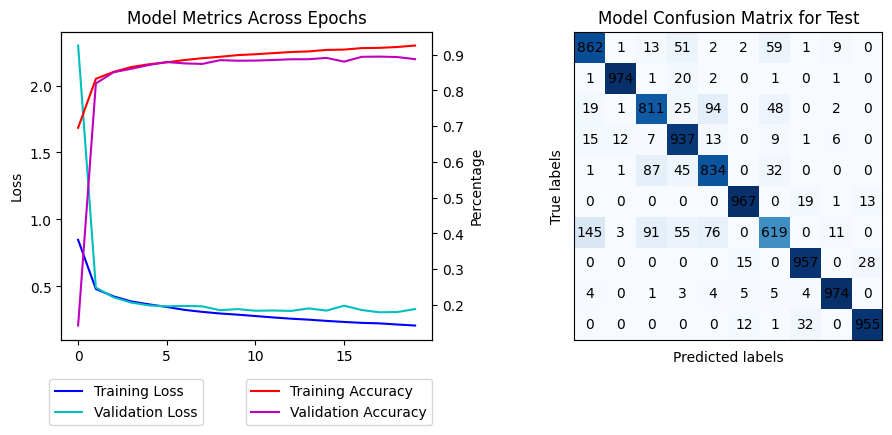

In [14]:
DropModelTrainer = ModelTrainer(DropModel, nn.CrossEntropyLoss(), torch.optim.SGD(DropModel.parameters(), lr=config.lr, momentum=0.9), MulticlassAccuracy, "Classification",  config.device, 10)

t0 = datetime.now()

DropModelTrainer.fit(trainLoader, validateLoader, config.EPOCHS)
t1 = datetime.now()
DropModelTrainer.Test_Model(testLoader)

print("\nTest Accuracy:", DropModelTrainer.Metrics["Test Accuracy"], "\nTime to Train:", t1 - t0)

DropModelTrainer.model.to("cpu")
DropModelTrainer.Graph_Metrics()

### How do the training results change compared to the baseline and weight penalties?
Once again within the graph we see a further reduction in the generalization gap between the validation and training. The result is actually more significant than when weight decay is added. Meaning dropout has a better generalization result than weight decay. Dropping random nodes each iteration allows the model to have to use other nodes to make predictions and update those nodes during training.

In [15]:
PretrainedModel = copy.deepcopy(BaseModelTrainer.model)
PretrainedModel.insert(5, nn.Dropout(0.3))
PretrainedModel.insert(8, nn.Dropout(0.3))
print(PretrainedModel)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
  (9): Linear(in_features=64, out_features=10, bias=True)
)


### 1.d Repeat problems 1.b and 1.c; This time, load the pre-trained parameters from the storage 20pts

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.85it/s]


EPOCH: 1
Training Loss: 0.2765917837337295  | Validation Loss: 0.35082460496019807
Training Accuracy: 0.9038605690002441  | Validation Accuracy: 0.8928150534629822


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.80it/s]


EPOCH: 2
Training Loss: 0.22728588094855373  | Validation Loss: 0.33713517956277156
Training Accuracy: 0.9197676777839661  | Validation Accuracy: 0.8883301615715027


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.61it/s]


EPOCH: 3
Training Loss: 0.2174543230772301  | Validation Loss: 0.34248441457748413
Training Accuracy: 0.9239029884338379  | Validation Accuracy: 0.8876380324363708


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.31it/s]


EPOCH: 4
Training Loss: 0.2135268266520229  | Validation Loss: 0.33786390119410575
Training Accuracy: 0.9247429370880127  | Validation Accuracy: 0.8907183408737183


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.44it/s]


EPOCH: 5
Training Loss: 0.19697699944766778  | Validation Loss: 0.32162378982026524
Training Accuracy: 0.9291988015174866  | Validation Accuracy: 0.8952246308326721


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.27it/s]


EPOCH: 6
Training Loss: 0.19536042511816273  | Validation Loss: 0.34405489884158397
Training Accuracy: 0.9317461252212524  | Validation Accuracy: 0.8920700550079346


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.26it/s]


EPOCH: 7
Training Loss: 0.1890270443747959  | Validation Loss: 0.3180681584363288
Training Accuracy: 0.9334509372711182  | Validation Accuracy: 0.8960849642753601


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 45.94it/s]


EPOCH: 8
Training Loss: 0.17926527833415998  | Validation Loss: 0.3270618928239701
Training Accuracy: 0.9360345005989075  | Validation Accuracy: 0.894496738910675


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.19it/s]


EPOCH: 9
Training Loss: 0.17337407189381632  | Validation Loss: 0.35029246356893096
Training Accuracy: 0.9376247525215149  | Validation Accuracy: 0.8866727352142334


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.16it/s]


EPOCH: 10
Training Loss: 0.1728276337245347  | Validation Loss: 0.3549989515796621
Training Accuracy: 0.9379090666770935  | Validation Accuracy: 0.8908510208129883


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:10<00:00, 39.45it/s]


EPOCH: 11
Training Loss: 0.16759274183150152  | Validation Loss: 0.3505780392504753
Training Accuracy: 0.9407923817634583  | Validation Accuracy: 0.8948951363563538


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.47it/s]


EPOCH: 12
Training Loss: 0.1574581050494977  | Validation Loss: 0.353991725026293
Training Accuracy: 0.9444806575775146  | Validation Accuracy: 0.8963768482208252


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.89it/s]


EPOCH: 13
Training Loss: 0.15844255570163376  | Validation Loss: 0.37377941386496766
Training Accuracy: 0.94278484582901  | Validation Accuracy: 0.8924496173858643


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:12<00:00, 35.03it/s]


EPOCH: 14
Training Loss: 0.15112466087909107  | Validation Loss: 0.3542163568608304
Training Accuracy: 0.9460114240646362  | Validation Accuracy: 0.8939142227172852


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.96it/s]


EPOCH: 15
Training Loss: 0.1495304275392356  | Validation Loss: 0.3593387981044485
Training Accuracy: 0.9455723762512207  | Validation Accuracy: 0.895823061466217


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.75it/s]


EPOCH: 16
Training Loss: 0.146635469887847  | Validation Loss: 0.35916860306516607
Training Accuracy: 0.9465685486793518  | Validation Accuracy: 0.8918358087539673


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 36.04it/s]


EPOCH: 17
Training Loss: 0.14314792199298668  | Validation Loss: 0.3565906695228942
Training Accuracy: 0.9481997489929199  | Validation Accuracy: 0.8913129568099976


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 35.60it/s]


EPOCH: 18
Training Loss: 0.13725340271907113  | Validation Loss: 0.3613033817803606
Training Accuracy: 0.9509133696556091  | Validation Accuracy: 0.8972964882850647


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:11<00:00, 37.13it/s]


EPOCH: 19
Training Loss: 0.13623392938578863  | Validation Loss: 0.3799487767701453
Training Accuracy: 0.950642466545105  | Validation Accuracy: 0.8912846446037292


100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:09<00:00, 43.83it/s]


EPOCH: 20
Training Loss: 0.13165172687356505  | Validation Loss: 0.39758582032741385
Training Accuracy: 0.9529191255569458  | Validation Accuracy: 0.8884039521217346

Test Accuracy: 0.8919999599456787 
Time to Train: 0:04:35.318307


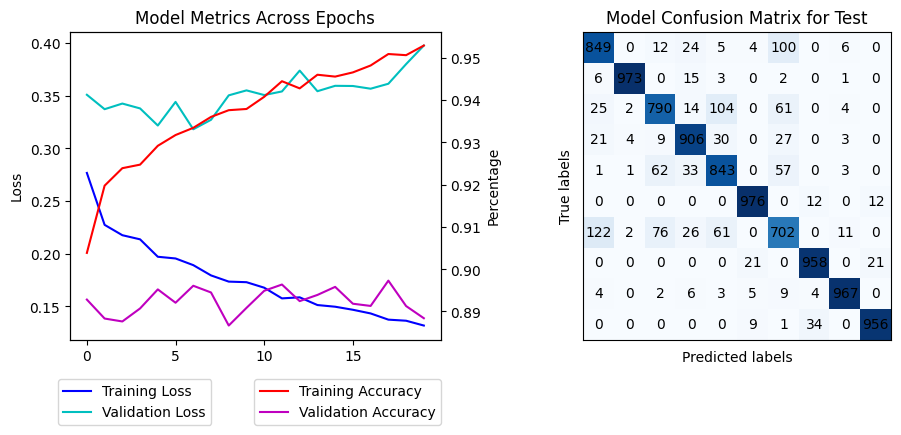

In [16]:
PretrainedModelTrainer = ModelTrainer(PretrainedModel, nn.CrossEntropyLoss(), torch.optim.SGD(PretrainedModel.parameters(), lr=config.lr, momentum=0.9, weight_decay=0.0001), MulticlassAccuracy, "Classification", config.device, 10)

t0 = datetime.now()

PretrainedModelTrainer.fit(trainLoader, validateLoader, config.EPOCHS)
t1 = datetime.now()
PretrainedModelTrainer.Test_Model(testLoader)

print("\nTest Accuracy:", PretrainedModelTrainer.Metrics["Test Accuracy"], "\nTime to Train:", t1 - t0)

PretrainedModelTrainer.model.to("cpu")
PretrainedModelTrainer.Graph_Metrics()

### Compare the training time and number of epochs needed against 1.b and 1.c. 20pts
Base = 4:15

Decay = 4:37

Drop = 4:26

Pre-T = 4:35

The decay seems to add an extra 20 seconds or so to training ( RTX 3080 10GB ) while the drop model seems to require only an extra 10 seconds of training time. With the Pretrained with weight decay and dropoout having about the same time as the Decay model. The base model seems to take a shorter amount of epochs to settle while the other models, drop and decay, setting much later towards 15 Epochs or so. However there is a much smaller generalization gap between them all.

Prediction Values: tensor([[  2.5170,  -1.6920,  16.7883,  -3.8060,   8.7974,  -2.9128,   3.3370,
          -6.8409,  -4.6725, -10.4738]]) 2


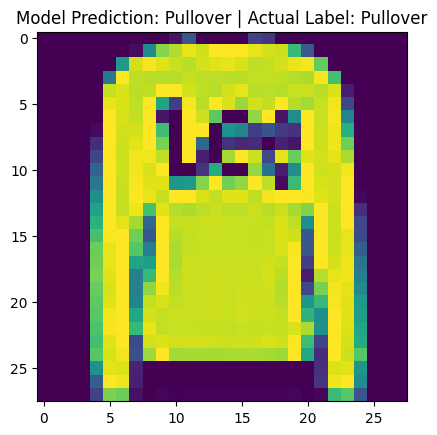

In [61]:
img, label = test_dataset[1]

# Make a prediction based on test data
with torch.no_grad():
    pred = PretrainedModel(img.reshape(1,1,28,28)) # Replicate a batch with single image
    pred_cls = torch.argmax(pred).item()

img = np.array(img).reshape((28, 28, 1))

# View some of the testing data and model predictions
print("Prediction Values:", pred, pred_cls)
plt.imshow(img)
_=plt.title(f"Model Prediction: {definitions[pred_cls]} | Actual Label: {definitions[label]}")

## Problem 2 Housing Dataset

In [14]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, root, EPOCHS, LR, batchSize):
        self.root = root
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.train_validate_percent = 0.90
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Configuration(root="datasets/HomePrices/", EPOCHS=20, LR=0.003, batchSize=32)

In [15]:
train_csv = pd.read_csv(config.root+"train.csv")
test_csv = pd.read_csv(config.root+"test.csv")
train_csv.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 2.a What happens if we need to standardize the continuous numerical features? 10pts
Standardizing the features gives the model a better understanding of the distrubution of the data. It allows the model to better predict values since they are within a pre-defined range. The weights of the model are better able to adapt to the dataset. The data will now have a mean of 0 and a standard deviation of 1.

In [16]:
def preprocess(train, test, label='SalePrice'):
    
    features = pd.concat((train.drop(columns=['Id', label]), test.drop(columns=['Id'])))
    numeric_features = features.dtypes[features.dtypes != 'object'].index
    
    features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
    features[numeric_features] = features[numeric_features].fillna(0)
    features = pd.get_dummies(features, dummy_na=True)
    
    train_csv = features[:train.shape[0]].copy()
    
    normVals = (train[label].mean(), train[label].std())
    print(normVals)
    
    train_csv[label] = ( train[label] - normVals[0] ) / normVals[1]
    test_csv = features[train.shape[0]:].copy()
    
    return train_csv, test_csv

In [17]:
pro_train_csv, pro_test_csv = preprocess(train_csv, test_csv)
pro_train_csv.head()

(180921.19589041095, 79442.50288288662)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,SalePrice
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,1,0,0,0,0,0,1,0,0,0.347154
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,1,0,0,0,0,0,1,0,0,0.007286
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,1,0,0,0,0,0,1,0,0,0.535970
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,1,0,1,0,0,0,0,0,0,-0.515105
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,1,0,0,0,0,0,1,0,0,0.869545


In [18]:
lectureModel = nn.Sequential(
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(10),
)


class HousingModel(nn.Module):
    def __init__(self):
        super(HousingModel, self).__init__()
        
        # Determined from output data 
        self.mean = 180921.19589041095
        self.std = 79442.50288288662
        self.unNormalize = False    
        self.Dropout = False
        self.D1 = nn.Dropout(0.3)
        
        self.layer1 = nn.LazyLinear(256)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.LazyLinear(256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.LazyLinear(128)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.LazyLinear(1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)  
        x = self.relu2(x)
        if self.Dropout:
            x = self.D1(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        
        # Out the normalization after training is complete
        if self.unNormalize:
            x = x * self.std + self.mean
        
        return x

housingModel = HousingModel()

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
# Simple custom housing dataset
class housing_dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        dimensions = torch.Tensor(row.values)
        label = dimensions[-1]
        
        return (dimensions[:-1], label)

In [20]:
train_dataset_housing = housing_dataset(pro_train_csv)

validNum = int(len(train_dataset_housing) * config.train_validate_percent)
train_dataset_housing, valid_dataset_housing = random_split(train_dataset_housing, [validNum, len(train_dataset_housing) - validNum])

trainLoaderHousing = DataLoader(train_dataset_housing, batch_size=config.bs, shuffle=True, num_workers=0)
validateLoaderHousing = DataLoader(valid_dataset_housing, batch_size=config.bs, shuffle=True, num_workers=0)

### 2.b Improve the score by improving the model complexity

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 86%|█████████████████████████████████████████████████████████████████████▍           | 36/42 [00:00<00:00, 117.46it/s]C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different

EPOCH: 1
Training Loss: 0.7784811776308787  | Validation Loss: 0.8612303733825684


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 109.09it/s]


EPOCH: 2
Training Loss: 0.2787889712711885  | Validation Loss: 0.33825902044773104


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 144.33it/s]


EPOCH: 3
Training Loss: 0.2093064600069608  | Validation Loss: 0.13485100269317626


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 148.94it/s]


EPOCH: 4
Training Loss: 0.1865333207838592  | Validation Loss: 0.1210961639881134


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 146.34it/s]


EPOCH: 5
Training Loss: 0.1731827807657066  | Validation Loss: 0.11097840815782548


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 146.34it/s]


EPOCH: 6
Training Loss: 0.16367223468564807  | Validation Loss: 0.0996519684791565


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 147.11it/s]


EPOCH: 7
Training Loss: 0.1519490745184677  | Validation Loss: 0.09706960171461106


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 148.41it/s]


EPOCH: 8
Training Loss: 0.15089068863363492  | Validation Loss: 0.10039720386266708


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 143.34it/s]


EPOCH: 9
Training Loss: 0.1433055212809926  | Validation Loss: 0.0886411115527153


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 145.83it/s]


EPOCH: 10
Training Loss: 0.13319278832170225  | Validation Loss: 0.10341267436742782


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 148.41it/s]


EPOCH: 11
Training Loss: 0.12864491414456142  | Validation Loss: 0.08194089531898499


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 143.84it/s]


EPOCH: 12
Training Loss: 0.12603297031351499  | Validation Loss: 0.08548827320337296


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 147.11it/s]


EPOCH: 13
Training Loss: 0.12159728172368237  | Validation Loss: 0.10141722857952118


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 140.23it/s]


EPOCH: 14
Training Loss: 0.1223911853241069  | Validation Loss: 0.08325557857751846


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 140.24it/s]


EPOCH: 15
Training Loss: 0.11866520682261103  | Validation Loss: 0.07953126430511474


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 130.23it/s]


EPOCH: 16
Training Loss: 0.11259522994181939  | Validation Loss: 0.08923850059509278


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 137.25it/s]


EPOCH: 17
Training Loss: 0.1109888068888159  | Validation Loss: 0.08411282151937485


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 130.43it/s]


EPOCH: 18
Training Loss: 0.10599883996127617  | Validation Loss: 0.08446943014860153


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 123.89it/s]


EPOCH: 19
Training Loss: 0.10563899181960594  | Validation Loss: 0.08011212274432182


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 127.27it/s]


EPOCH: 20
Training Loss: 0.10175916233233043  | Validation Loss: 0.08030761182308196
Time to Train: 0:00:06.812999


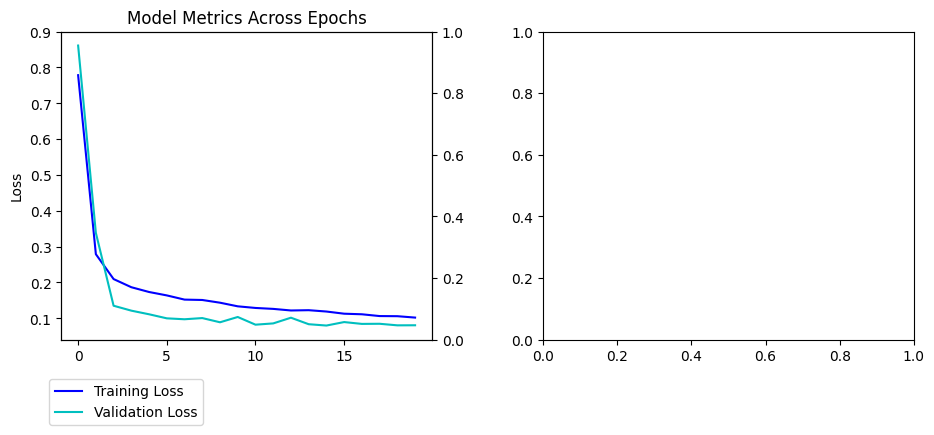

In [21]:
from utils.Trainer import ModelTrainer

LectureModel = copy.deepcopy(lectureModel)
LectureHousingTrainer = ModelTrainer(LectureModel, nn.MSELoss(), torch.optim.SGD(LectureModel.parameters(), lr=config.lr, momentum=0.9), nn.MSELoss(), "Regression",  config.device)

t0 = datetime.now()

LectureHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, config.EPOCHS)
t1 = datetime.now()

print("Time to Train:", t1 - t0)
LectureHousingTrainer.model.to("cpu")
LectureHousingTrainer.Graph_Metrics()

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 116.50it/s]


EPOCH: 1
Training Loss: 0.9549666827633267  | Validation Loss: 0.8112511336803436


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 107.28it/s]


EPOCH: 2
Training Loss: 0.4567020677384876  | Validation Loss: 0.6517143487930298


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 136.59it/s]


EPOCH: 3
Training Loss: 0.20199081922570863  | Validation Loss: 0.1344958908855915


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 140.23it/s]


EPOCH: 4
Training Loss: 0.17544545836391903  | Validation Loss: 0.10688659474253655


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 140.94it/s]


EPOCH: 5
Training Loss: 0.1581030257401012  | Validation Loss: 0.09681389406323433


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 138.84it/s]


EPOCH: 6
Training Loss: 0.13125767869253954  | Validation Loss: 0.10282623618841172


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 141.18it/s]


EPOCH: 7
Training Loss: 0.1159558075347117  | Validation Loss: 0.09019685089588166


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 134.83it/s]


EPOCH: 8
Training Loss: 0.10881643762279834  | Validation Loss: 0.1090308040380478


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 136.59it/s]


EPOCH: 9
Training Loss: 0.09527666046051309  | Validation Loss: 0.08501822054386139


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 141.18it/s]


EPOCH: 10
Training Loss: 0.08373909787994871  | Validation Loss: 0.07863801270723343


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 137.03it/s]


EPOCH: 11
Training Loss: 0.07494814676188287  | Validation Loss: 0.07294543534517288


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 139.07it/s]


EPOCH: 12
Training Loss: 0.07204698026180267  | Validation Loss: 0.08819386214017869


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 127.47it/s]


EPOCH: 13
Training Loss: 0.06583736943347114  | Validation Loss: 0.08486773073673248


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 138.16it/s]


EPOCH: 14
Training Loss: 0.0596395983759846  | Validation Loss: 0.07464595809578896


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 123.35it/s]


EPOCH: 15
Training Loss: 0.059312384542343874  | Validation Loss: 0.10197704508900643


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 132.91it/s]


EPOCH: 16
Training Loss: 0.05184782535902092  | Validation Loss: 0.08115520179271699


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 122.09it/s]


EPOCH: 17
Training Loss: 0.04577197586851461  | Validation Loss: 0.09495070204138756


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 130.64it/s]


EPOCH: 18
Training Loss: 0.04138136819182407  | Validation Loss: 0.07830380499362946


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 109.09it/s]


EPOCH: 19
Training Loss: 0.04031723278153333  | Validation Loss: 0.0775583915412426


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 130.44it/s]


EPOCH: 20
Training Loss: 0.03476245566049502  | Validation Loss: 0.0954616166651249
Time to Train: 0:00:07.133502


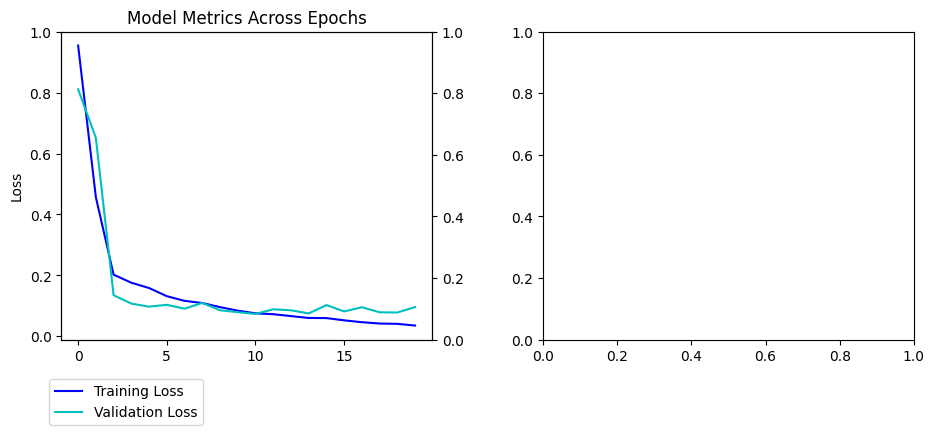

In [22]:
base_housingModel = copy.deepcopy(housingModel)
ComplexHousingTrainer = ModelTrainer(base_housingModel, nn.MSELoss(), torch.optim.SGD(base_housingModel.parameters(), lr=config.lr, momentum=0.9), nn.MSELoss(), "Regression",  config.device)

t0 = datetime.now()

ComplexHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, config.EPOCHS)
t1 = datetime.now()

print("Time to Train:", t1 - t0)
ComplexHousingTrainer.model.to("cpu")
ComplexHousingTrainer.Graph_Metrics()

### How about the model complexity comparison and training time?
The different models, the lecture model and the complex model. The complex model showed higher accuacury 

### 2.c How about exploring options for weight decay and dropout over the more complex model? 10pts

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 114.13it/s]


EPOCH: 1
Training Loss: 0.9697980923312051  | Validation Loss: 0.8237460732460022


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 116.35it/s]


EPOCH: 2
Training Loss: 0.48849658641432014  | Validation Loss: 0.7445569634437561


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 121.56it/s]


EPOCH: 3
Training Loss: 0.25149856560996603  | Validation Loss: 0.13867366015911103


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 118.14it/s]


EPOCH: 4
Training Loss: 0.19178472029133922  | Validation Loss: 0.1257820799946785


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 119.32it/s]


EPOCH: 5
Training Loss: 0.19862719980024157  | Validation Loss: 0.1205750659108162


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 109.38it/s]


EPOCH: 6
Training Loss: 0.17933562025427818  | Validation Loss: 0.1265287548303604


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 132.91it/s]


EPOCH: 7
Training Loss: 0.15019178807380654  | Validation Loss: 0.10276509225368499


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 132.91it/s]


EPOCH: 8
Training Loss: 0.2099103398088898  | Validation Loss: 0.1330026850104332


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 136.59it/s]


EPOCH: 9
Training Loss: 0.1755870707732226  | Validation Loss: 0.12138722389936447


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 134.40it/s]


EPOCH: 10
Training Loss: 0.12154135724440926  | Validation Loss: 0.08991838991641998


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 137.48it/s]


EPOCH: 11
Training Loss: 0.1063853558152914  | Validation Loss: 0.07862920202314853


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 125.56it/s]


EPOCH: 12
Training Loss: 0.10625244654892456  | Validation Loss: 0.08194376826286316


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 137.26it/s]


EPOCH: 13
Training Loss: 0.09248706308149156  | Validation Loss: 0.08388991057872772


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 134.83it/s]


EPOCH: 14
Training Loss: 0.09037228296732619  | Validation Loss: 0.0783226665109396


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 133.97it/s]


EPOCH: 15
Training Loss: 0.07962730628926129  | Validation Loss: 0.09069651812314987


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 137.93it/s]


EPOCH: 16
Training Loss: 0.0860767848346205  | Validation Loss: 0.0949533797800541


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 129.23it/s]


EPOCH: 17
Training Loss: 0.07264238651952751  | Validation Loss: 0.08699187338352203


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 129.43it/s]


EPOCH: 18
Training Loss: 0.06902188142495495  | Validation Loss: 0.08561644926667214


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 121.21it/s]


EPOCH: 19
Training Loss: 0.06253024230578116  | Validation Loss: 0.08175139725208283


100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 120.69it/s]


EPOCH: 20
Training Loss: 0.05983178960602908  | Validation Loss: 0.0929573118686676
Time to Train: 0:00:07.133502


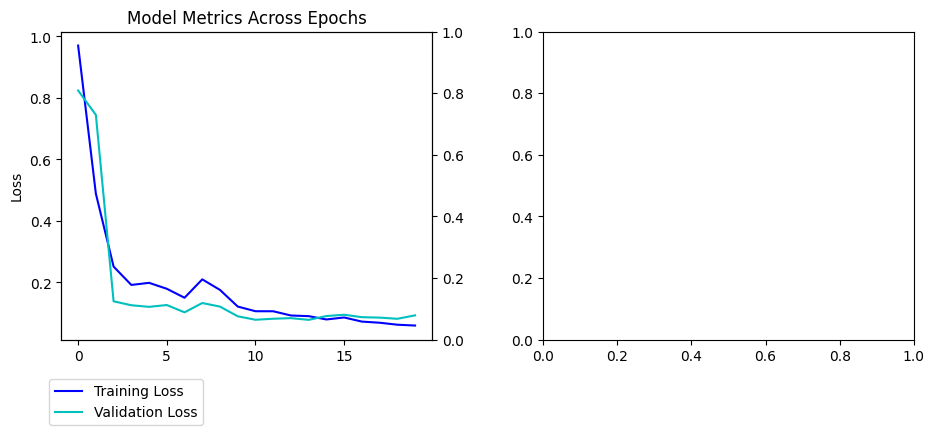

In [42]:
drop_decay_housingModel = copy.deepcopy(housingModel)
drop_decay_housingModel.Dropout = True

DropHousingTrainer = ModelTrainer(drop_decay_housingModel, nn.MSELoss(), torch.optim.SGD(drop_decay_housingModel.parameters(), lr=config.lr, momentum=0.9, weight_decay=0.0001), nn.MSELoss(), "Regression",  config.device)

DropHousingTrainer.fit(trainLoaderHousing, validateLoaderHousing, config.EPOCHS)

print("Time to Train:", t1 - t0)
DropHousingTrainer.model.to("cpu")
DropHousingTrainer.Graph_Metrics()

### Please plot the results and compare them against 2.b
Very similar in pattern however the generalization gap is much smaller in the weight decayed and dropout model

In [24]:
DropHousingTrainer.model.Dropout = False
DropHousingTrainer.model.unNormalize = True
torch.save(DropHousingTrainer.model.state_dict(), 'DropHousing.pt')

In [41]:
preds = torch.tensor(pro_test_csv.values, dtype=torch.float32)
print(preds.shape)
DropHousingTrainer.model.eval()
kagglePredictions = DropHousingTrainer.model(preds).reshape(-1)
print(kagglePredictions.shape, test_csv.Id.shape)
submission = pd.DataFrame({'Id': test_csv.Id,'SalePrice':kagglePredictions.detach().numpy()})
display(submission)
submission.to_csv('submission.csv', index=False)

torch.Size([1459, 331])
torch.Size([1459]) (1459,)


,Id,SalePrice
0,1461,120301.617188
1,1462,141822.093750
2,1463,184861.390625
3,1464,194178.781250
4,1465,181809.578125
...,...,...
1454,2915,94027.078125
1455,2916,94215.593750
1456,2917,173767.671875
1457,2918,116028.640625


### Submission Result 5pts
#### 815/3932

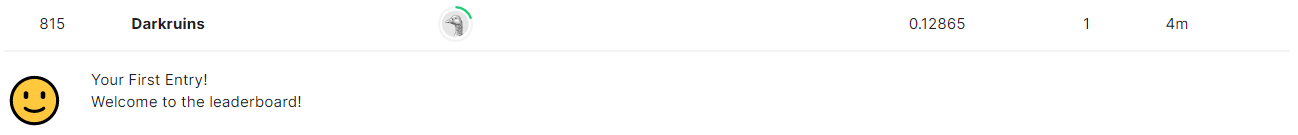